# Run Seurat de novo integration

June 23, 2021

Run Seurat de novo integration on all datasets.

In [31]:
suppressPackageStartupMessages({
    library(Seurat)
    library(ggplot2)
    library(patchwork)
    library(ggrastr)
    library(ggthemes)
    library(matrixStats)
    library(tidyverse)
})

# Load pancreas data

Follow steps from https://satijalab.org/seurat/v3.2/integration.html

In [10]:
exprs_norm = readRDS('../../data/Fig4_pancreas_multi/combined_exprs_norm_new_mouse.rds')
metadata = readRDS('../../data/Fig4_pancreas_multi/all_meta.rds')
vargenestouse = read.csv('../../data/Fig4_pancreas_multi/denovo_top1000perdataset_total2650_vargenes.csv')

all(colnames(exprs_norm) == rownames(metadata))

[1] TRUE

In [11]:
system.time({

exprs_norm_vargenes = exprs_norm[vargenestouse$symbol, ]

denovo = CreateSeuratObject(counts = exprs_norm_vargenes, project = "pancreas")
denovo@meta.data = metadata
table(denovo@meta.data$batch)
pancreas.list = SplitObject(denovo, split.by = "batch")
    
for (i in 1:length(pancreas.list)) {
#     pancreas.list[[i]] <- NormalizeData(pancreas.list[[i]], verbose = FALSE) # data already normalized
    VariableFeatures(pancreas.list[[i]]) = vargenestouse$symbol
}

# Next, we identify anchors using the FindIntegrationAnchors function, which takes a list of Seurat objects as input.
set.seed(0)
pancreas.anchors <- FindIntegrationAnchors(object.list = pancreas.list, dims = 1:20, 
                                           anchor.features = 2650, verbose = FALSE)

# We then pass these anchors to the IntegrateData function, which returns a Seurat object.
# The returned object will contain a new Assay, which holds an integrated (or 'batch-corrected') 
# expression matrix for all cells, 
# enabling them to be jointly analyzed
set.seed(0)
pancreas.integrated <- IntegrateData(anchorset = pancreas.anchors, dims = 1:20) # default is 30
DefaultAssay(pancreas.integrated) <- "integrated"

})

Merging dataset 3 into 2

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Merging dataset 10 into 9

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Merging dataset 1 into 4

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Merging dataset 5 into 6

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Merging dataset 8 into 2 3

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Merging dataset 4 1 into 2 3 8

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Merging dataset 6 5 into 7

Extracting anchors for merged samples

Finding integration vectors

Finding

   user  system elapsed 
539.258 350.140 488.976 

In [13]:
# Run the standard workflow for visualization and clustering
system.time({
    set.seed(0)
    pancreas.integrated <- ScaleData(pancreas.integrated, verbose = FALSE)
    pancreas.integrated <- RunPCA(pancreas.integrated, npcs = 20, verbose = FALSE)
    pancreas.integrated <- RunUMAP(pancreas.integrated, reduction = "pca", dims = 1:20, verbose = FALSE)
})

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


   user  system elapsed 
 61.875   8.877  36.233 

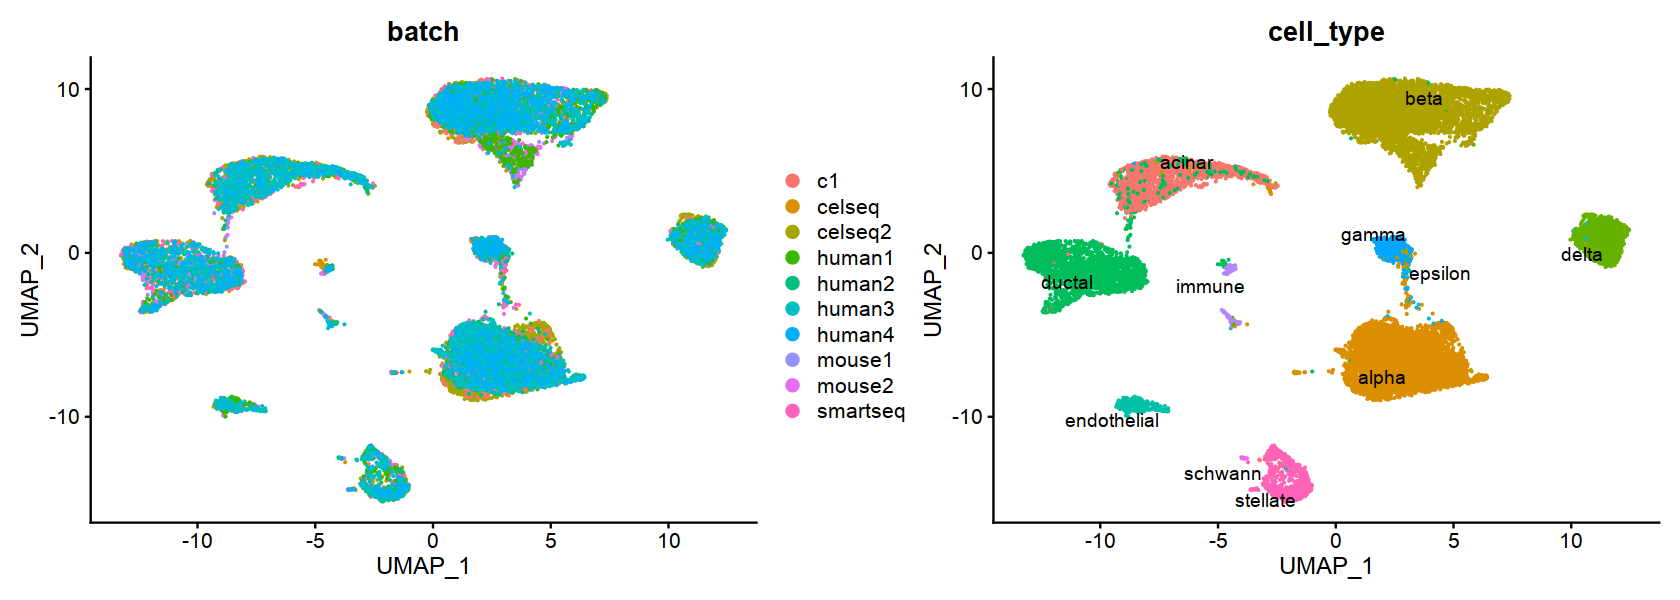

In [14]:
options(repr.plot.height = 5, repr.plot.width = 14)
p1 <- DimPlot(pancreas.integrated, reduction = "umap", group.by = "batch", pt.size = 0.1)
p2 <- DimPlot(pancreas.integrated, reduction = "umap", group.by = "cell_type", pt.size = 0.1, label = TRUE, 
    repel = TRUE) + NoLegend()
p1 + p2 

In [22]:
saveRDS(pancreas.integrated, "Seurat_de_novo_integration_obj.rds")

In [23]:
pancreas.integrated = readRDS("Seurat_de_novo_integration_obj.rds")

In [18]:
inte_umap <- Embeddings(pancreas.integrated, reduction = "umap")
inte_umap <- as.data.frame(inte_umap)
inte_umap$batch <- as.character(pancreas.integrated@meta.data$batch)
inte_umap$cell_type <- as.character(pancreas.integrated@meta.data$cell_type)
inte_umap[1:4,]

,UMAP_1,UMAP_2,batch,cell_type
,<dbl>,<dbl>,<chr>,<chr>
celseq_D2ex_1,-6.266882,4.5308098,celseq,acinar
celseq_D2ex_2,-6.974083,5.7455405,celseq,acinar
celseq_D2ex_3,-6.281273,5.4181818,celseq,acinar
celseq_D2ex_4,-12.545324,-0.3340106,celseq,ductal


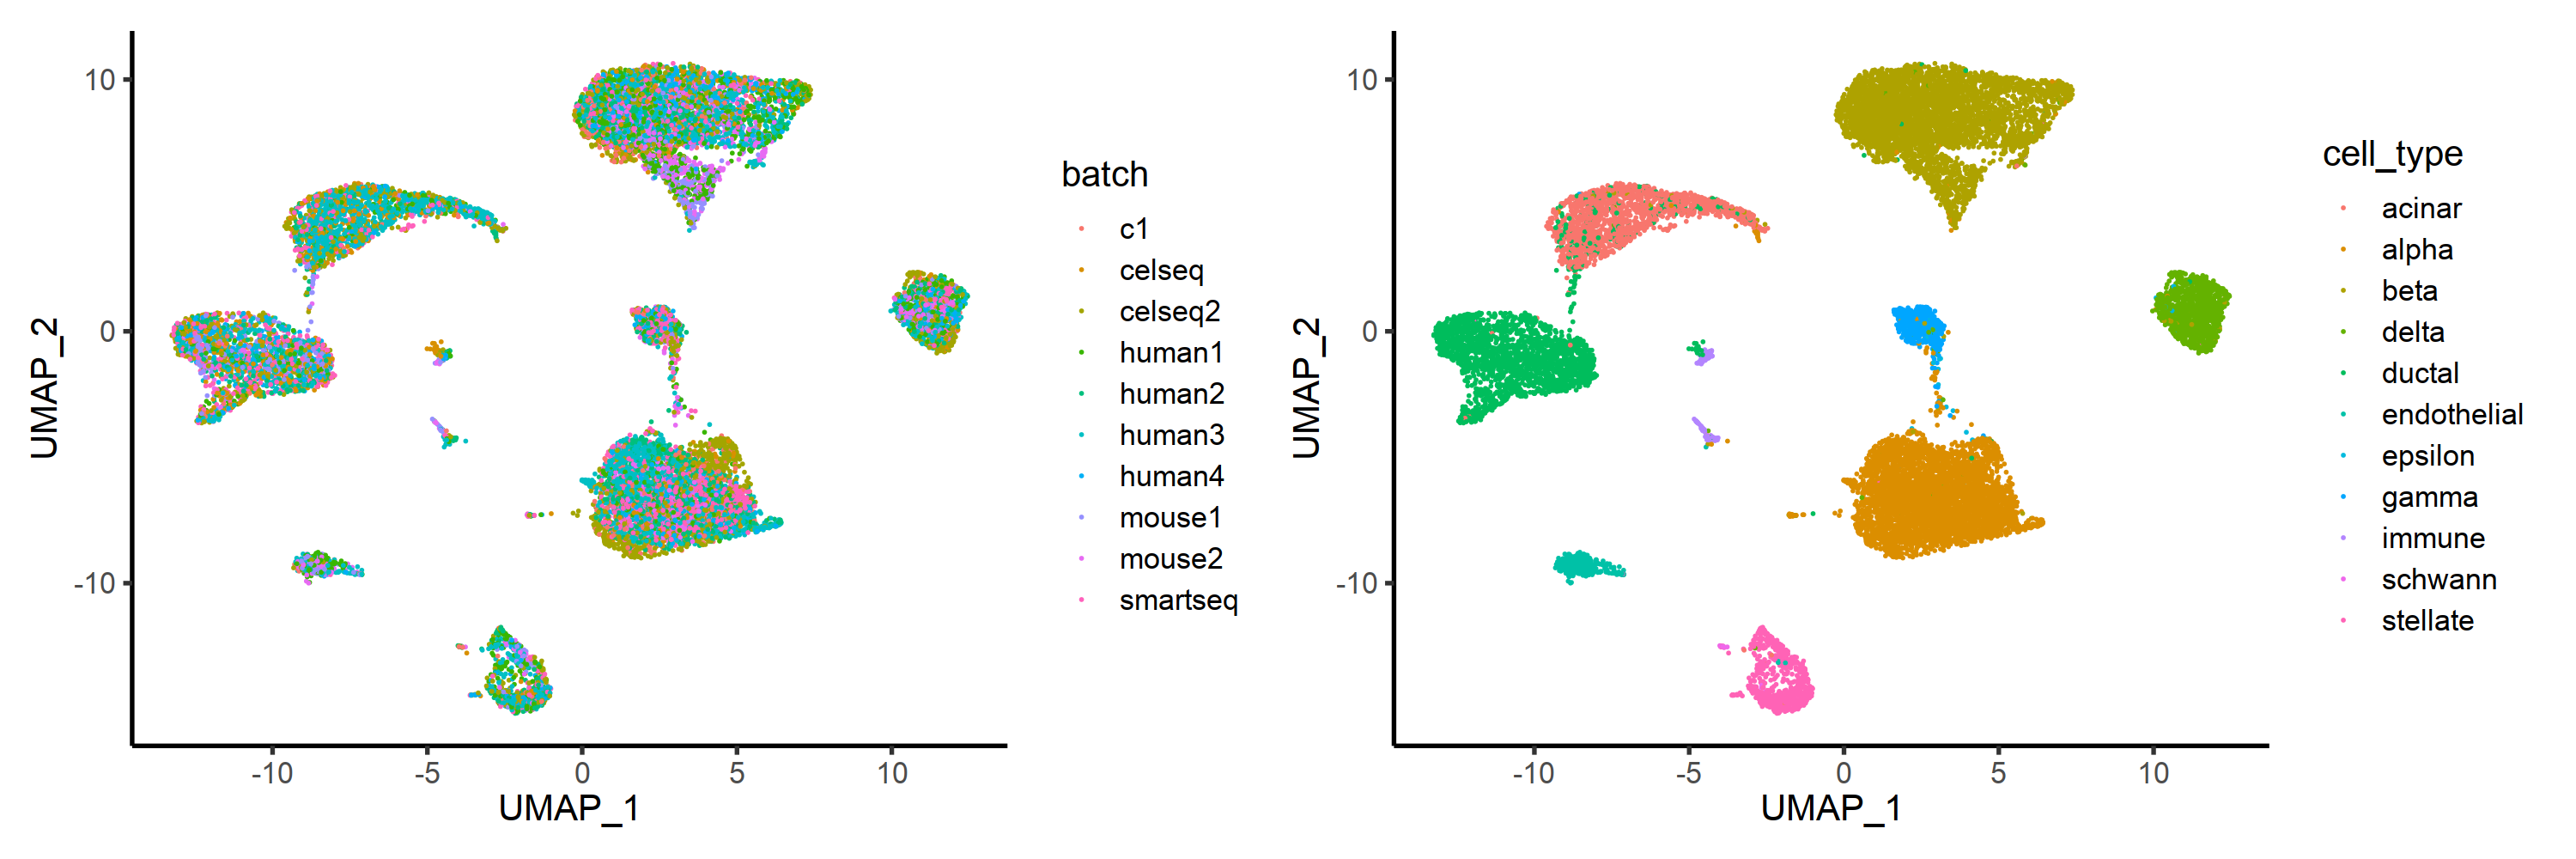

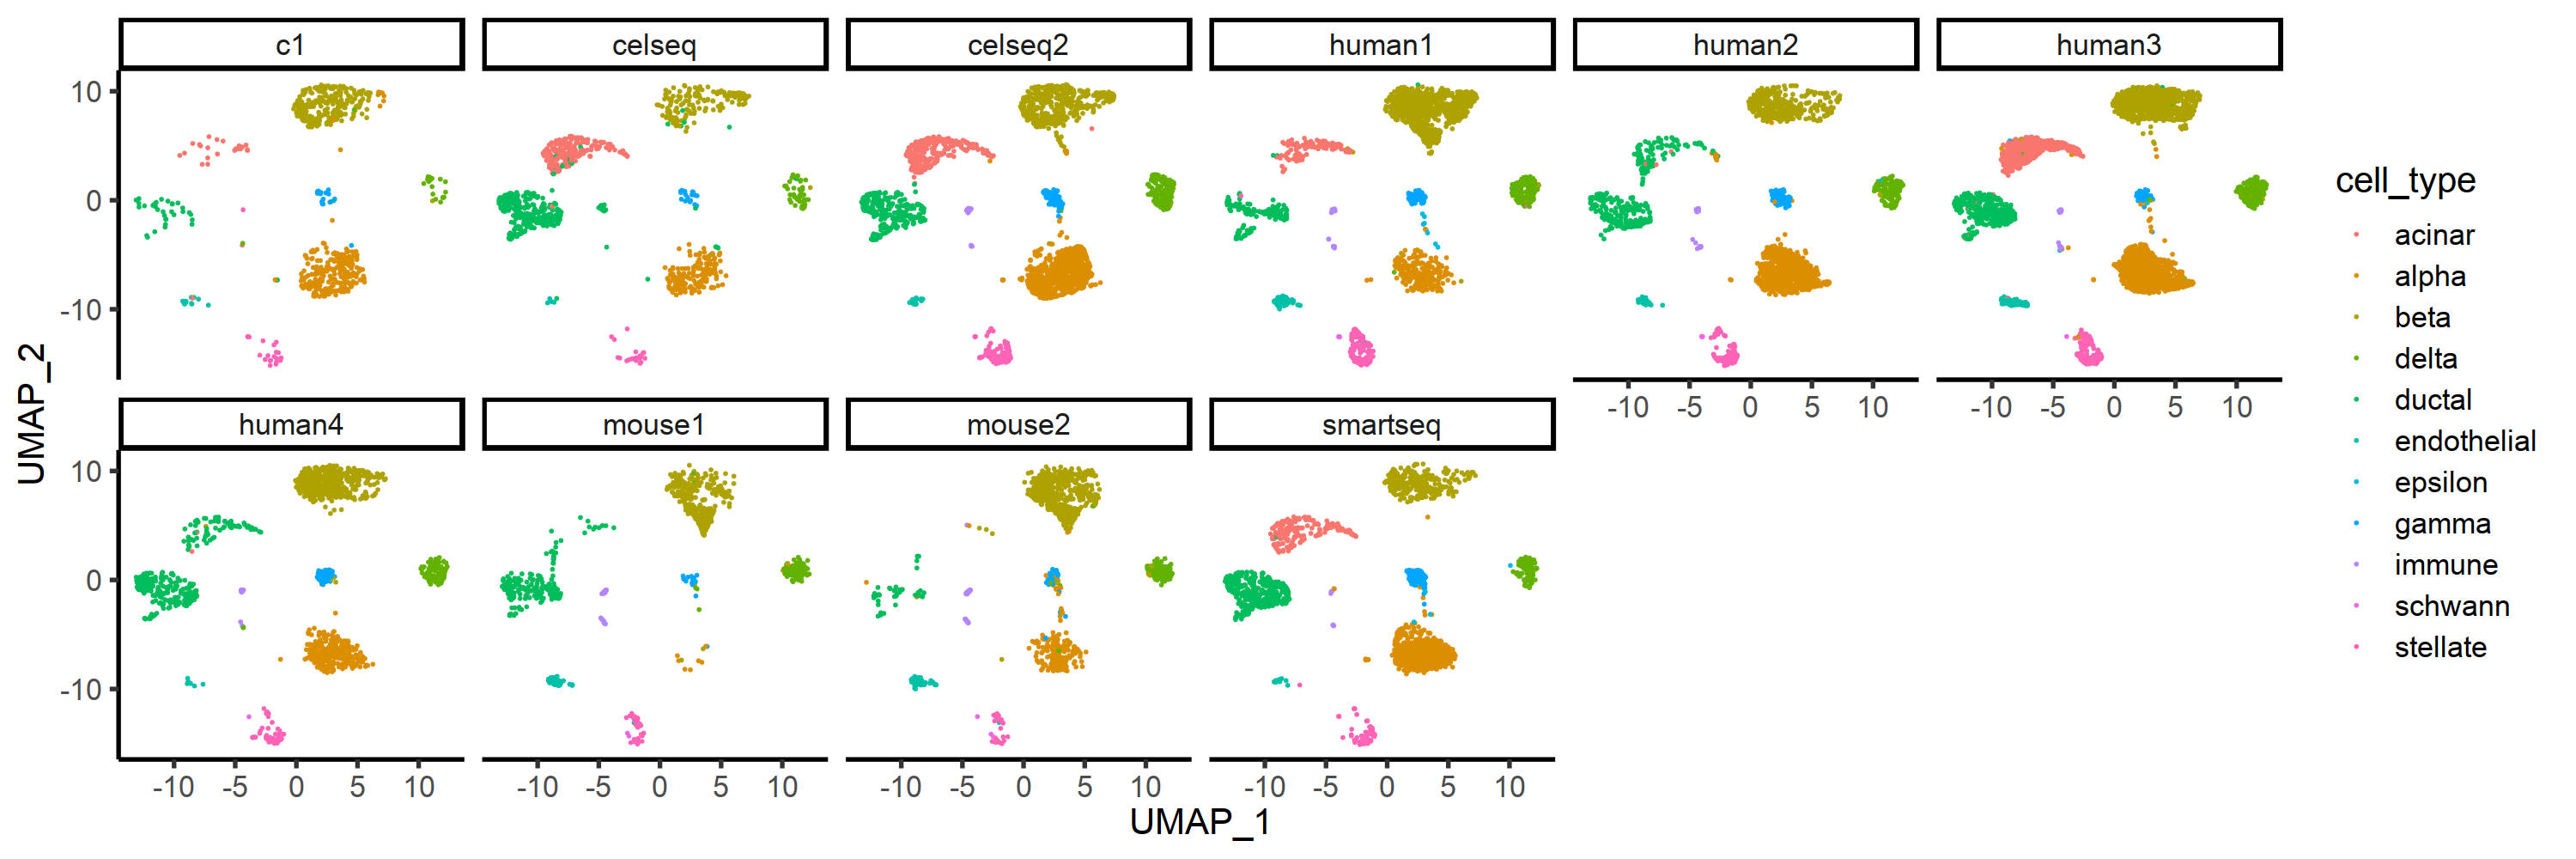

In [19]:
options(repr.plot.height = 5, repr.plot.width = 15, repr.plot.res = 200)
p1 <- ggplot() +
  geom_point(
    data = inte_umap[sample(nrow(inte_umap)),],
    mapping = aes_string(x = "UMAP_1", y = "UMAP_2", fill = "batch"),
    size = 0.8, stroke = 0.001, shape = 21) +
    theme_classic(base_size = 15) +
    theme(panel.grid = element_blank()) 

p2 <- ggplot() +
  geom_point(
    data = inte_umap[sample(nrow(inte_umap)),],
    mapping = aes_string(x = "UMAP_1", y = "UMAP_2", fill = "cell_type"),
    size = 0.8, stroke = 0.001, shape = 21) +
    theme_classic(base_size = 15) +
    theme(panel.grid = element_blank()) 
p1 + p2


ggplot() +
  geom_point(
    data = inte_umap[sample(nrow(inte_umap)),],
    mapping = aes_string(x = "UMAP_1", y = "UMAP_2", fill = "cell_type"),
    size = 0.8, stroke = 0.001, shape = 21) +
  facet_wrap(batch ~ ., ncol = 6) +
    theme_classic(base_size = 15) +
    theme(panel.grid = element_blank())

In [20]:
embedding = Embeddings(pancreas.integrated, reduction = "pca")
saveRDS(embedding, 'Seurat_de_novo_integration_embedding.rds')

In [21]:
embedding = readRDS('Seurat_de_novo_integration_embedding.rds')
dim(embedding)
head(embedding)

[1] 16342    20

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,PC_11,PC_12,PC_13,PC_14,PC_15,PC_16,PC_17,PC_18,PC_19,PC_20
celseq_D2ex_1,-14.05197,8.581130,-2.1500259,13.550650,-6.828743,2.753137,-0.03322801,1.858917,-0.54623612,-0.1114473,0.9900206,1.5336444,-2.8195816,0.4383482,0.7331565,4.8500799,0.2051950,0.1205738,1.0904299,-2.7718913
celseq_D2ex_2,-15.41117,8.148112,-2.0310900,13.174649,-6.894542,1.592763,-0.30531036,-5.504278,0.28512849,-0.3591856,-0.5296906,-2.2444665,1.9709539,0.3069065,1.0777693,0.6216282,0.6307216,-1.6724695,1.3327150,1.2104536
celseq_D2ex_3,-13.63631,9.157322,-2.0859142,14.486558,-7.824390,1.643621,-2.81727246,-2.447044,0.51218291,-0.5036005,1.4582698,-0.6914455,-0.2828271,0.7458097,0.6829696,-0.1652733,-1.0962814,-2.6886709,1.8386383,1.8741101
celseq_D2ex_4,-24.11969,12.692376,0.1030727,-13.040039,7.447586,-1.236977,0.80870688,-10.408481,0.06529908,1.6765322,2.6976490,-0.5224219,3.0300483,1.2106030,-0.9489324,1.6904293,-0.1085460,1.2007108,2.2952167,-1.0744381
celseq_D2ex_5,-24.23032,10.778480,-0.6415820,-10.215894,4.329168,0.123748,1.65073617,-8.475382,-0.48078270,2.0181821,-0.1369907,-2.1154190,3.1398654,-0.9184820,2.8280182,0.7074667,-0.7159086,3.7684923,-1.1166264,1.9124240
celseq_D2ex_6,-17.25485,6.226718,-1.0016712,-8.657604,3.205546,1.461200,0.82292147,9.895032,0.85006216,-0.1676165,6.6400538,-0.5891522,-2.5430223,0.7080589,0.3351777,2.3879791,0.2925295,-0.9670614,0.4879403,-0.6075137


In [24]:
message('Run de novo UMAP on de novo integrated cells')
set.seed(0)
umap <- uwot::umap(embedding, n_neighbors = 30, learning_rate = 0.5, init = "laplacian", 
        metric = 'cosine', fast_sgd = FALSE, n_sgd_threads = 1,
        min_dist = .3, n_threads = 4, ret_model = TRUE) # min_dist is 0.1 for python umap default, 0.3 for Seurat
colnames(umap$embedding) = c('UMAP1', 'UMAP2')
all_meta = cbind(metadata, umap$embedding)

Run de novo UMAP on de novo integrated cells



null device 
          1

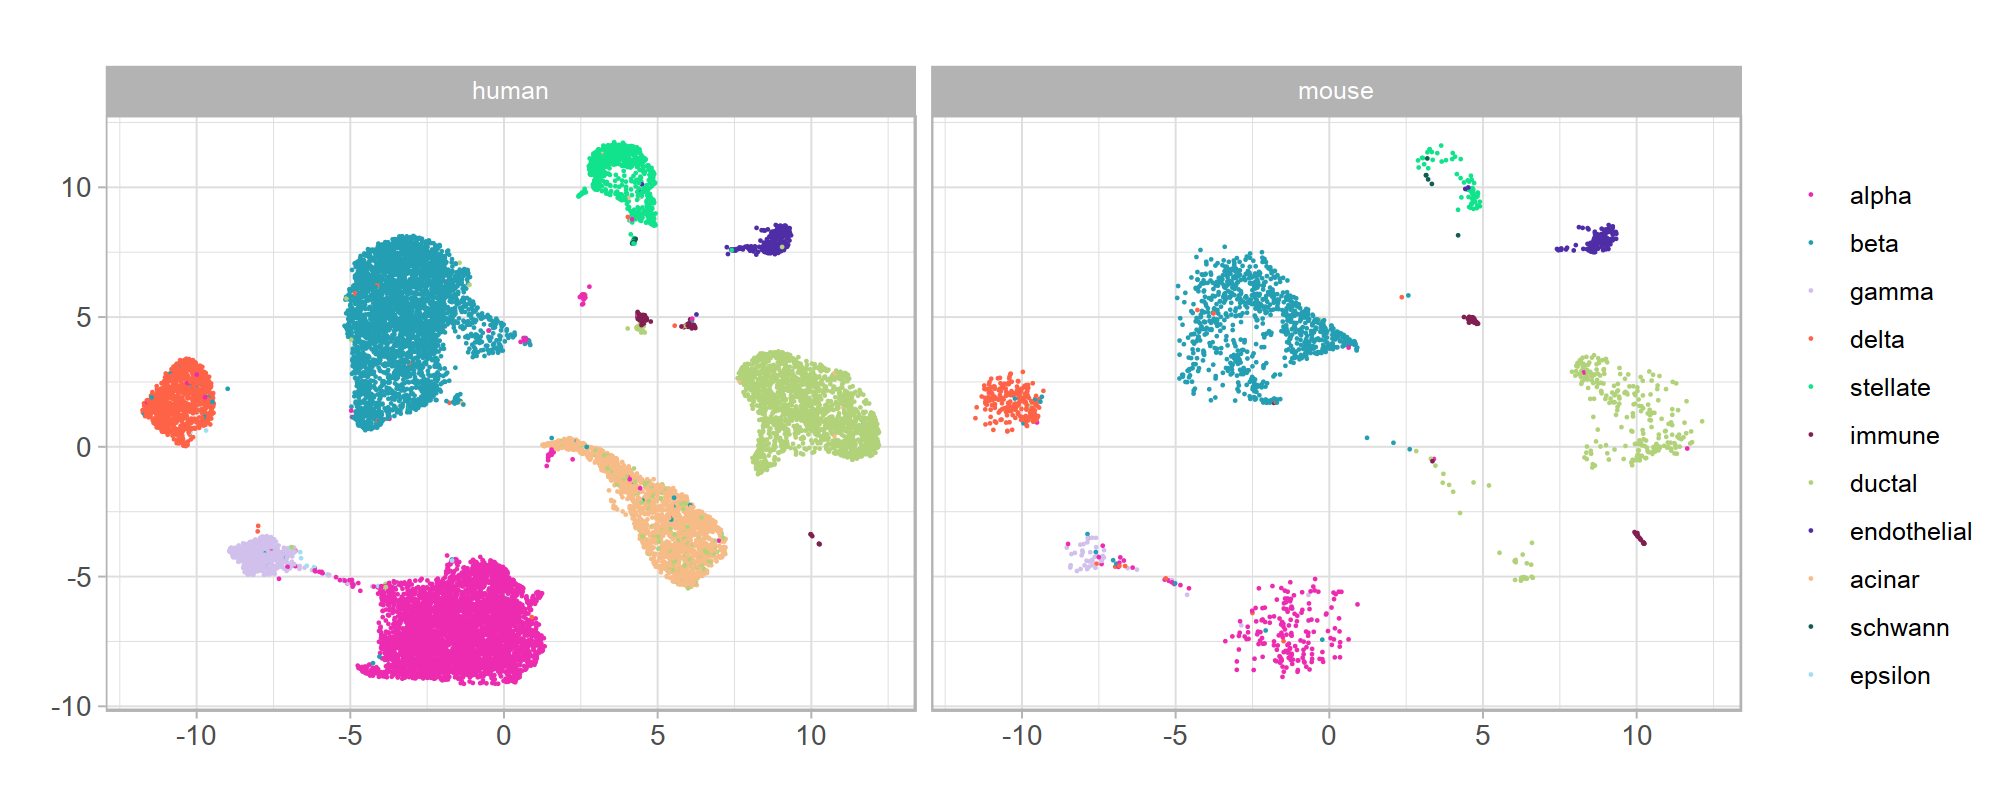

In [27]:
celltype.colors = c('alpha' = "#ed2bb1",
                    'beta' = "#239eb3",
                    'gamma' = "#d1bfec",
                    'delta' = "#FF6347",
                    'stellate' = "#11e38c",
                    'immune' = "#812050",
                    'ductal' = "#b2d27a",
                    'endothelial' = "#4e2da6",
                    'acinar' = "#f6bb86",
                    'schwann' = "#115d52",
                    'epsilon' = "#a1def0")

## Plot de novo integration
options(repr.plot.height = 4, repr.plot.width = 10)

p = all_meta %>%
    sample_frac(1L) %>% # permute rows randomly
    ggplot(aes(x = UMAP1, y = UMAP2)) +
    geom_point(aes(color = cell_type), size =0.3, shape = 16) +
    theme_light() +
    labs(title = '', color = '', fill = '') +
    theme(plot.title = element_text(hjust = 0.5)) + 
    scale_color_manual(values = celltype.colors) +
    theme(legend.position = "right") +
    theme(axis.text=element_text(size=10)) + xlab('') + ylab('') +
    facet_wrap(~species)
print(p)
dev.off()

In [28]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server release 6.5 (Santiago)

Matrix products: default
BLAS/LAPACK: /PHShome/jbk37/anaconda3/envs/seurat4/lib/libopenblasp-r0.3.15.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] forcats_0.5.1      stringr_1.4.0      dplyr_1.0.7        purrr_0.3.4       
 [5] readr_1.4.0        tidyr_1.1.3        tibble_3.1.2       tidyverse_1.3.1   
 [9] matrixStats_0.59.0 ggthemes_4.2.4     ggrastr_0.2.3      patchwork_1.1.1   
[13] ggplot2_3.3.4     